<a href="https://www.kaggle.com/code/maciejk111/chest-x-ray-pneumonia-nn-image-classification?scriptVersionId=128342014" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import random
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline


My project is a neural network designed to classify chest x-ray scans and detect cases of pneumonia. The motivation behind this project is to create a tool that can aid medical professionals in accurately and quickly diagnosing pneumonia, a common and potentially life-threatening condition. Through the use of advanced machine learning techniques, my neural network can analyze chest x-ray images with a high degree of accuracy and provide valuable insights to assist medical professionals in their decision-making process. I am excited about the potential impact that this project can have in the medical field and hope that it can contribute to improving patient outcomes.

importing tools that I need


Here I import my dataset. Dataset is downloaded from here https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia, but I edited the data structure deleted some subfolders and put in order to my liking. Here I also check if the length is correct and if it has proper number of classes (it indeed has).

In [2]:
dataset = ImageFolder('/kaggle/input/pneunomiaset/pneunomiamyset')
print(len(dataset))
print(len(dataset.classes))

5856
2


Let's shuffle the data inside and create test,train and val dataset. That's way I'm prefering to do always if I work with dataset that is not customly made by me. After that dividig data i check each subset length. 

In [3]:
random_seed = 42
torch.cuda.manual_seed_all(random_seed)
torch.manual_seed(random_seed);

test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.05
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size




train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

4451 234 1171


Images in my dataset are in the PIL format so i need to applay more transformations in order to get dataset with data augumentation.

1


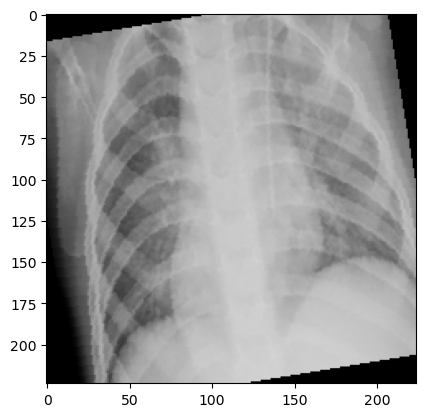

In [4]:
class chest_Xray_pneumonia(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label
        
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([

    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(), 
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),

])

train_dataset = chest_Xray_pneumonia(train_ds, train_transform)
val_dataset = chest_Xray_pneumonia(val_ds, val_transform)
test_dataset = chest_Xray_pneumonia(test_ds, test_transform)

img, label = train_dataset[random.randint(0,100)]
print(label)
plt.imshow(img.permute(1,2,0))

Here i create Dataloaders.

In [5]:
batch_size =64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

Let's take a peek inside our batch

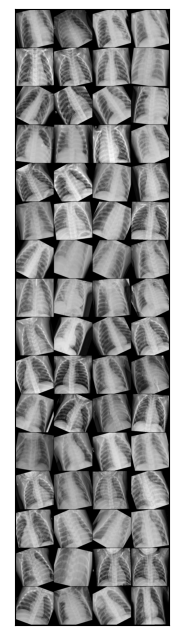

In [6]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=4).permute(1,2,0))
        break
        
show_batch(train_loader)

here I create accuracy function

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Here I define neural network model with the general base class for image classification and model "wide_resnet50", which was choosen by me due to it's general good performance - it achieves good accuracy while at the same time it does not consume that much of compilatory power

In [8]:
class ImageClassificationBase(nn.Module):
  
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss

    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        
    
    
class chest_xray_WideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet50_2(pretrained=True)
       
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

Here I create class Device data loader

In [9]:
model1 = chest_xray_WideResnet()
model1

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

chest_xray_WideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Here I move data to the GPU, the GPU I'm using is Tesla P100.

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)
    
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
    
    
device = get_default_device()
print(device)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

to_device(model1, device);

cuda


here i check my model

In [11]:
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_loader)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
outs.shape : torch.Size([64, 2])
outs :  tensor([[-0.9978, -0.4599],
        [-0.9296, -0.5021],
        [-0.9078, -0.5165],
        [-0.8556, -0.5534],
        [-0.8085, -0.5898],
        [-0.9874, -0.4661],
        [-1.1124, -0.3986],
        [-1.1798, -0.3672],
        [-0.8429, -0.5629],
        [-0.9230, -0.5064],
        [-1.0473, -0.4321],
        [-0.8927, -0.5268],
        [-0.7562, -0.6338],
        [-1.1305, -0.3899],
        [-0.9116, -0.5139],
        [-0.9749, -0.4736],
        [-0.9092, -0.5156],
        [-0.9578, -0.4841],
        [-1.3332, -0.3060],
        [-0.8546, -0.5542],
        [-1.0236, -0.4452],
        [-1.1895, -0.3630],
        [-0.7930, -0.6024],
        [-1.0608, -0.4249

importing loading bar for better visualisation

In [12]:
from tqdm.notebook import tqdm

Implementation of training and evaluation of my model. I have decided to use "train_one_cycle" which will change the learning rate after every batch of training

In [13]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader1, val_loader1, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader1))
    
    for epoch in range(epochs):
        
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader1):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            
           
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
        
            sched.step()
            
        result = evaluate(model, val_loader1)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader1):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader1]
    return model.validation_epoch_end(outputs)

In [14]:
evaluate(model1, val_loader)

{'val_loss': 0.579204797744751, 'val_acc': 0.7004716992378235}

setting hyperparameters

In [15]:
num_epochs = 6
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

lets get started 

In [16]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.3222, val_loss: 0.3024, val_acc: 0.8902


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.1077, val_loss: 0.1242, val_acc: 0.9466


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0848, val_loss: 0.1053, val_acc: 0.9631


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0683, val_loss: 0.1504, val_acc: 0.9545


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0593, val_loss: 0.1003, val_acc: 0.9522


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0435, val_loss: 0.0739, val_acc: 0.9678


In [17]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0394, val_loss: 0.1083, val_acc: 0.9592


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0375, val_loss: 0.0811, val_acc: 0.9631


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0346, val_loss: 0.0992, val_acc: 0.9592


In [18]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0343, val_loss: 0.0841, val_acc: 0.9631


  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0336, val_loss: 0.0887, val_acc: 0.9631


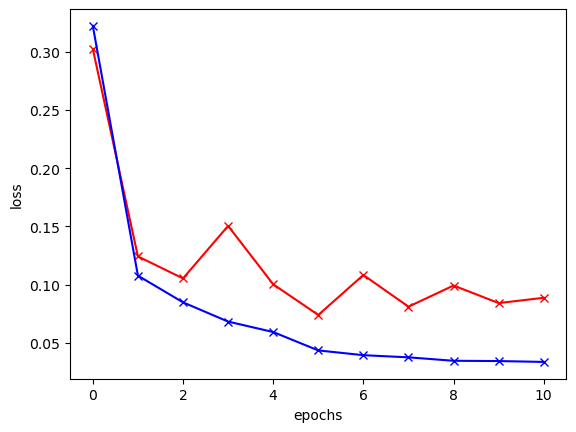

In [19]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    
    
    
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

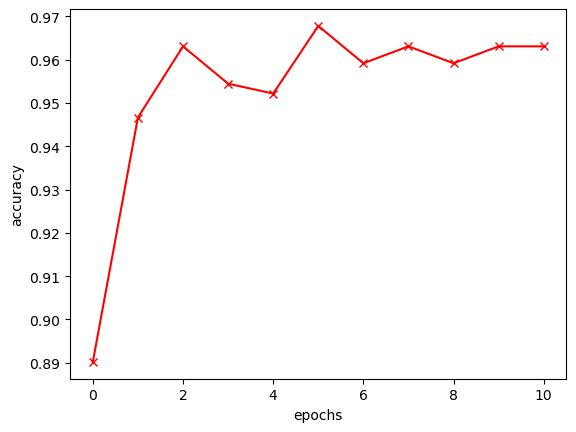

In [20]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

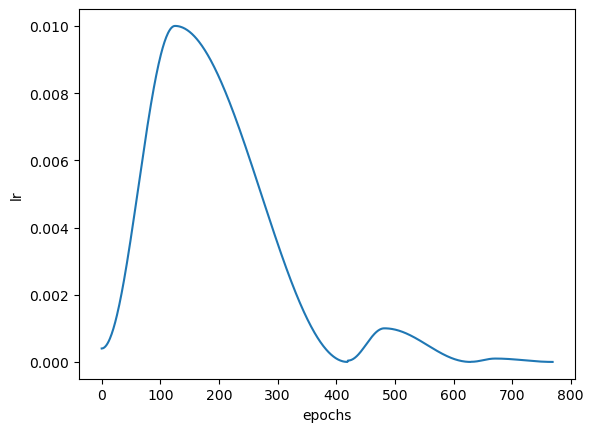

In [21]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

names for our classes 

In [22]:
lungs_status = []

def name(name):
        return name

for n in dataset.classes:
    lungs_status.append(name(n))
    
lungs_status

['NORMAL', 'PNEUMONIA']

In [23]:
def predict_single(img, label):
    xb = img.unsqueeze(0) 
    xb = to_device(xb, device)
    preds = model1(xb)                   
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', lungs_status[label], ' | Predicted :', lungs_status[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

let's test our model with test dataset

Actual : NORMAL  | Predicted : NORMAL


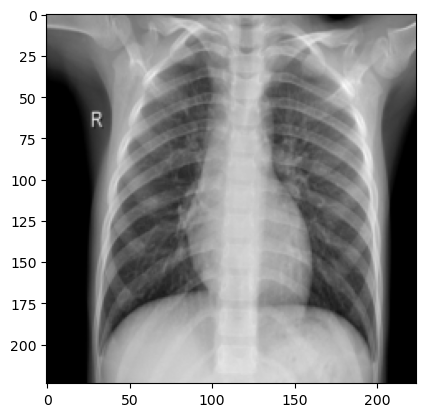

In [24]:
predict_single(*test_dataset[69])

 lets predict some more, lets say 10 with random labels

Actual : NORMAL  | Predicted : NORMAL


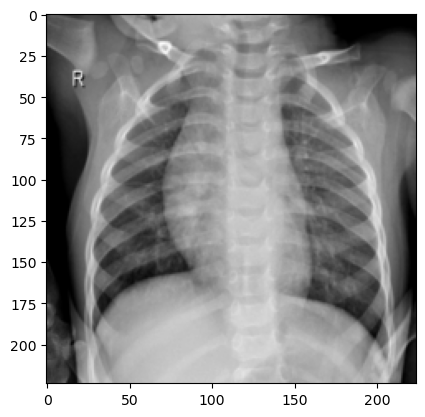

Actual : PNEUMONIA  | Predicted : PNEUMONIA


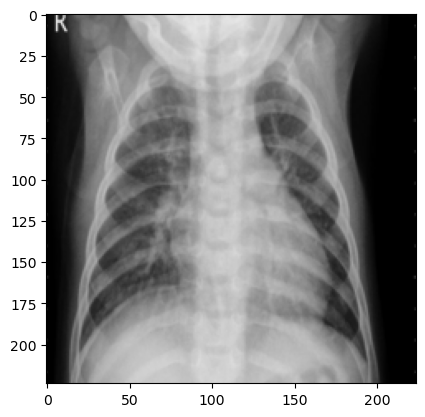

Actual : PNEUMONIA  | Predicted : PNEUMONIA


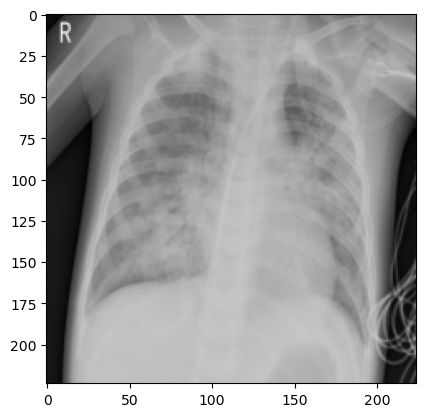

Actual : PNEUMONIA  | Predicted : PNEUMONIA


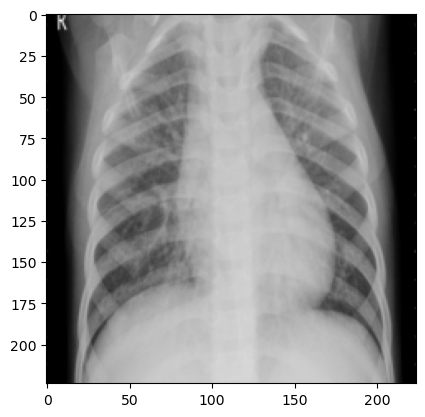

Actual : PNEUMONIA  | Predicted : PNEUMONIA


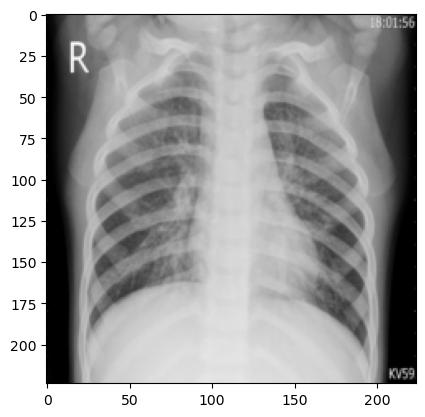

Actual : PNEUMONIA  | Predicted : PNEUMONIA


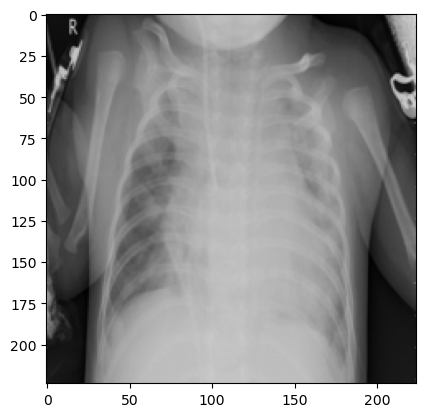

Actual : PNEUMONIA  | Predicted : PNEUMONIA


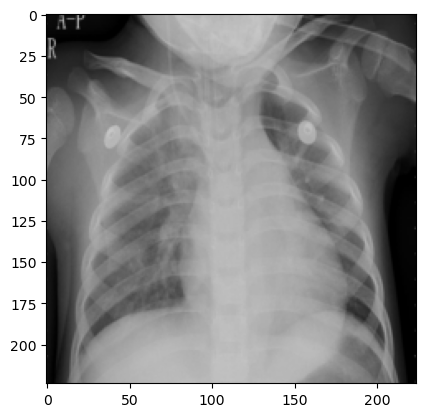

Actual : NORMAL  | Predicted : NORMAL


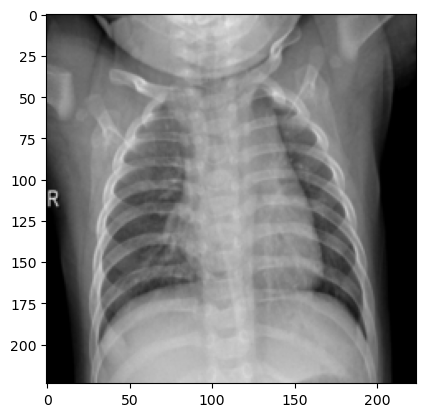

Actual : NORMAL  | Predicted : NORMAL


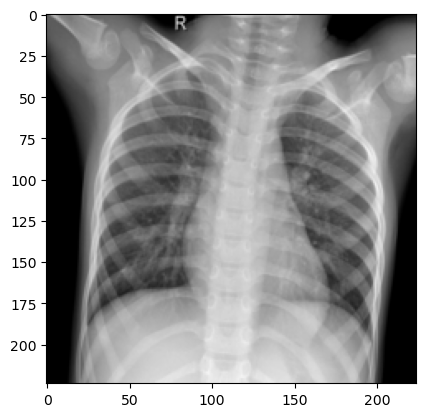

Actual : PNEUMONIA  | Predicted : PNEUMONIA


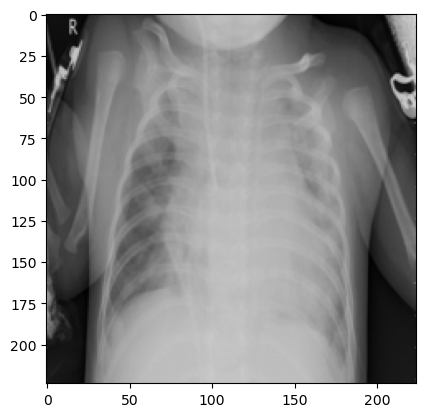

In [25]:
import random

for i in range(10):
    random_label = random.randint(1,1000 )
    img, label = test_dataset[random_label]
    predict_single(img, label)

nailed it! as expected!

In [26]:
test_dl = DeviceDataLoader(test_loader, device)
result = evaluate(model1, test_dl)
result

{'val_loss': 0.1106456071138382, 'val_acc': 0.9619243741035461}

Level of accuracy is 96,88%. Not that bad, right?


In [27]:
#now let's save our model
weights_fname = 'chest_X-ray_pneumonia-wideresnet_with_Daug.pth'
torch.save(model1.state_dict(), weights_fname)